# Data Loading

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jeetblahiri/bccd-dataset-with-mask")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bccd-dataset-with-mask' dataset.
Path to dataset files: /kaggle/input/bccd-dataset-with-mask


In [3]:
%cd /kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/

/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask


In [4]:
!ls

test  train


#Preprocessing

##Explore cell size and distribution

In [5]:
from skimage import measure
import os
import numpy as np
from skimage import io, color, morphology, filters, segmentation, measure, feature
from scipy import ndimage as ndi
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_opening, disk

import matplotlib.pyplot as plt

In [6]:
#checking file numbers in training
DATA_ROOT = './'
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train/original')
TRAIN_MASK_DIR = os.path.join(DATA_ROOT, 'train/mask')
TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test/original')
TEST_MASK_DIR = os.path.join(DATA_ROOT, 'test/mask')

In [7]:
TRAIN_MASKS = sorted(os.listdir(TRAIN_MASK_DIR))
TEST_MASKS = sorted(os.listdir(TEST_MASK_DIR))

In [8]:
def connected_components_instances_from_binary(fg, min_size=30, connectivity=1, open_radius=1):
    fg = morphology.remove_small_objects(fg, min_size=min_size)
    if open_radius and open_radius > 0:
        fg = binary_opening(fg, disk(open_radius))
        fg = morphology.remove_small_objects(fg, min_size=min_size)  # optional
    labels = measure.label(fg, connectivity=connectivity)
    return labels.astype(np.int32)


# white cells on dark background
def rgb_white_to_binary(mask_rgb, white_thresh=200):
    """
    Foreground = (255,255,255), background = (0,0,0)
    """
    m = mask_rgb.astype(np.uint8)
    return (m[..., 0] >= white_thresh) & (m[..., 1] >= white_thresh) & (m[..., 2] >= white_thresh)


def instance_stats(labels):
    """
    Per image stats based on masks
    """
    props = measure.regionprops(labels)
    areas = np.array([p.area for p in props], dtype=np.int32)
    return {
        "num_instances": len(props),
        "areas": areas,
        "mean_area": float(areas.mean()) if len(areas) else 0.0,
        "median_area": float(np.median(areas)) if len(areas) else 0.0
    }

In [9]:
mask_rgb = io.imread(os.path.join(TRAIN_MASK_DIR,TRAIN_MASKS[0]))  # shape (H,W,3), dtype uint8
fg = rgb_white_to_binary(mask_rgb, white_thresh=200)
labels = connected_components_instances_from_binary(fg, min_size=100, connectivity=1)
stats = instance_stats(labels)
print(stats["num_instances"], stats["mean_area"], stats["median_area"])

60 9141.6 9300.5


In [11]:
num_instances_train = []
num_instances_test = []
mean_area_train = []
mean_area_test = []
median_area_train = []
median_area_test = []

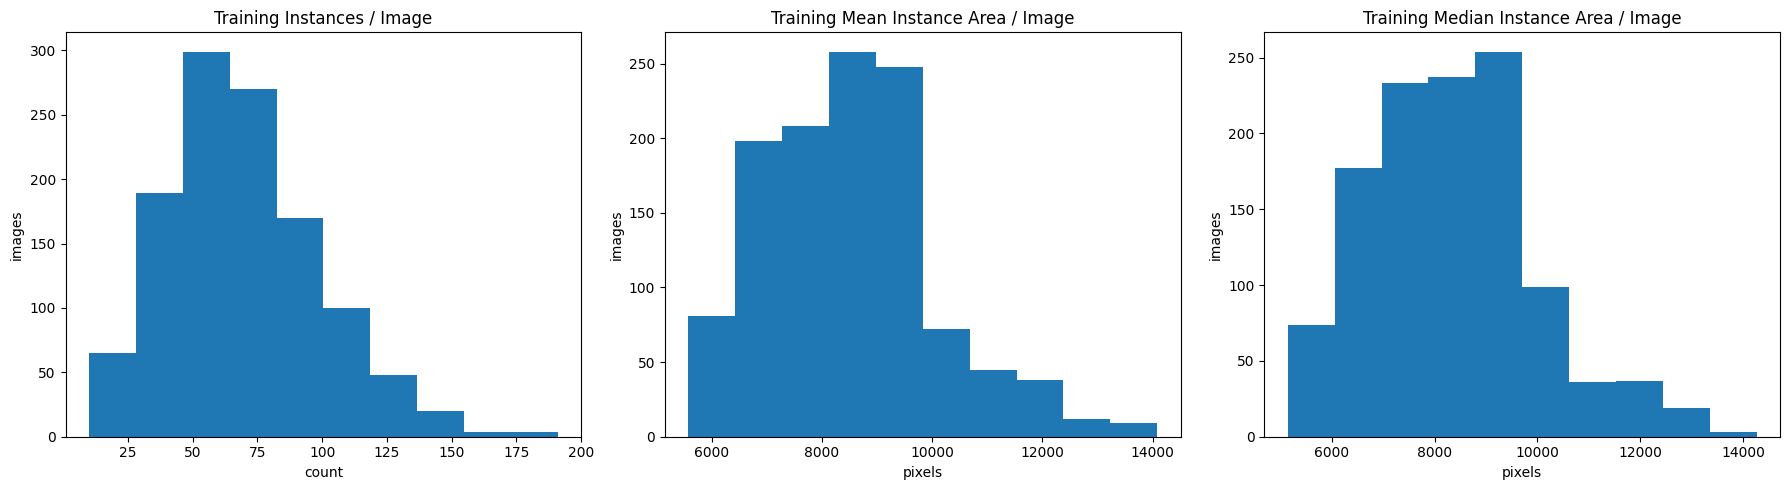

In [12]:
import matplotlib.pyplot as plt
for p in TRAIN_MASKS:
    mask_rgb = io.imread(os.path.join(TRAIN_MASK_DIR,p))
    fg = rgb_white_to_binary(mask_rgb, white_thresh=200)
    labels = connected_components_instances_from_binary(fg, min_size=100, connectivity=1)
    st = instance_stats(labels)
    num_instances_train.append(st["num_instances"])
    mean_area_train.append(st["mean_area"])
    median_area_train.append(st["median_area"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(num_instances_train, bins=10)
axes[0].set_title("Training Instances / Image")
axes[0].set_xlabel("count")
axes[0].set_ylabel("images")

axes[1].hist(mean_area_train, bins=10)
axes[1].set_title("Training Mean Instance Area / Image")
axes[1].set_xlabel("pixels")
axes[1].set_ylabel("images")

axes[2].hist(median_area_train, bins=10)
axes[2].set_title("Training Median Instance Area / Image")
axes[2].set_xlabel("pixels")
axes[2].set_ylabel("images")

plt.tight_layout()
plt.show()


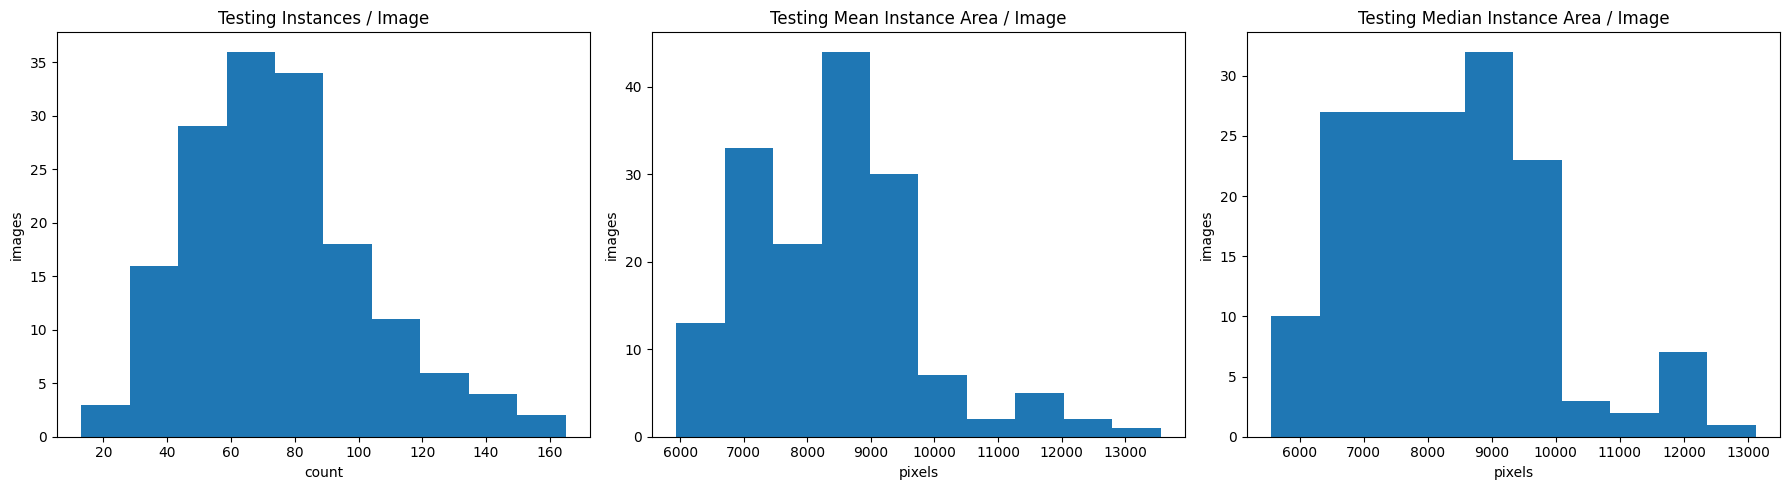

In [13]:
for p in TEST_MASKS:
    mask_rgb = io.imread(os.path.join(TEST_MASK_DIR,p))
    fg = rgb_white_to_binary(mask_rgb, white_thresh=200)
    labels = connected_components_instances_from_binary(fg, min_size=100, connectivity=1)
    st = instance_stats(labels)
    num_instances_test.append(st["num_instances"])
    mean_area_test.append(st["mean_area"])
    median_area_test.append(st["median_area"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(num_instances_test, bins=10)
axes[0].set_title("Testing Instances / Image")
axes[0].set_xlabel("count")
axes[0].set_ylabel("images")

axes[1].hist(mean_area_test, bins=10)
axes[1].set_title("Testing Mean Instance Area / Image")
axes[1].set_xlabel("pixels")
axes[1].set_ylabel("images")

axes[2].hist(median_area_test, bins=10)
axes[2].set_title("Testing Median Instance Area / Image")
axes[2].set_xlabel("pixels")
axes[2].set_ylabel("images")

plt.tight_layout()
plt.show()

In [14]:
idx = np.argsort(mean_area_train)
print(TRAIN_MASKS[idx[0]], num_instances_train[idx[0]], mean_area_train[idx[0]], median_area_train[idx[0]])
print(TRAIN_MASKS[idx[-1]], num_instances_train[idx[-1]], mean_area_train[idx[-1]], median_area_train[idx[-1]])

00d04a90-80e5-4bce-9511-1b64eabb7a47.png 130 5574.923076923077 5146.0
06bbcd42-3ba8-4476-8804-8455f56dd928.png 72 14085.680555555555 13995.5


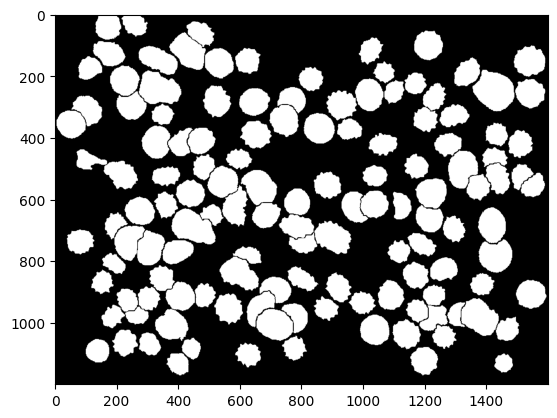

In [15]:
small_cells = io.imread(os.path.join(TRAIN_MASK_DIR,"00d04a90-80e5-4bce-9511-1b64eabb7a47.png"))
plt.imshow(small_cells)

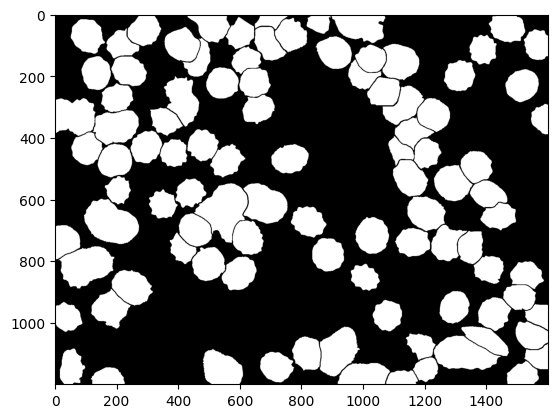

In [16]:
large_cells = io.imread(os.path.join(TRAIN_MASK_DIR,"082e1f81-4f49-44ad-b5bb-9dfc155b2ed8.png"))
plt.imshow(large_cells)

(np.float64(-0.5), np.float64(1599.5), np.float64(1199.5), np.float64(-0.5))

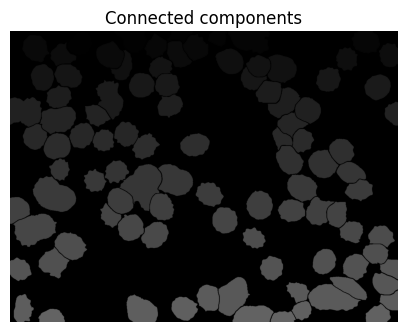

In [18]:
fg = large_cells > 0
inst = measure.label(fg, connectivity=1)

plt.figure(figsize=(5,5))
plt.imshow(inst, cmap="tab20")
plt.title("Connected components")
plt.axis("off")

In [19]:
print("num instances:", inst.max())

num instances: 100


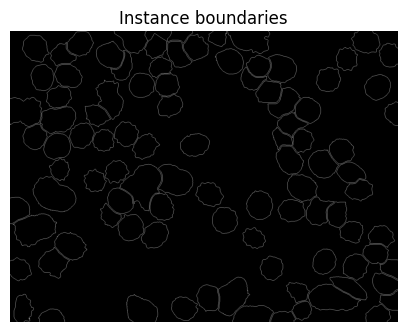

In [20]:
bnd_inst = find_boundaries(inst, mode="inner")

plt.figure(figsize=(5,5))
plt.imshow(bnd_inst.astype(np.float32), cmap="gray")
plt.title("Instance boundaries")
plt.axis("off")
plt.show()

## Splitting for Validation Set

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
image_files = sorted(os.listdir(TRAIN_IMG_DIR))

print(len(image_files))
print(image_files[:5]) #checking image names

mask_files = sorted(os.listdir(TRAIN_MASK_DIR))
print(len(mask_files))
print(mask_files[:5])

1169
['002f20ad-2ace-499c-9335-c9080bc3e6b5.png', '003a89b0-a095-417a-8dd6-f408339bbc68.png', '003d1cdc-0aec-430b-90e0-f4d82135b1ac.png', '005e60b6-77b8-458c-b57c-bfe0c7e7df78.png', '00a02700-2ea2-4590-9e15-ffc9160fd3de.png']
1169
['002f20ad-2ace-499c-9335-c9080bc3e6b5.png', '003a89b0-a095-417a-8dd6-f408339bbc68.png', '003d1cdc-0aec-430b-90e0-f4d82135b1ac.png', '005e60b6-77b8-458c-b57c-bfe0c7e7df78.png', '00a02700-2ea2-4590-9e15-ffc9160fd3de.png']


In [12]:
train_imgs, val_imgs = train_test_split(image_files,test_size=0.25,random_state=42)

print(f"Train images: {len(train_imgs)}")
print(f"Val images: {len(val_imgs)}")

suffix_origin = [f.split('.')[1] for f in image_files] #origin images contain 2 different types
print(set(suffix_origin))

suffix_mask = [f.split('.')[1] for f in mask_files]
print(set(suffix_mask))

Train images: 876
Val images: 293
{'png', 'jpg'}
{'png'}


## Cropping patches for training

In [13]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 60.0 MB/s eta 0:00:00


In [14]:
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from skimage import measure, morphology

import kornia.augmentation as K
from torch.utils.data import DataLoader

In [15]:
def _to_numpy_rgb(pil_img):
    # make sure of origin in uint8 RGB
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    return np.array(pil_img)

def _to_numpy_mask(pil_mask):
    # convert mask
    if pil_mask.mode != "L":
        pil_mask = pil_mask.convert("L")
    return np.array(pil_mask)

class BCCDRandomCropDataset(Dataset):
    """
    Random-crop sampler that:
      - loads full image + mask
      - samples a patch_size x patch_size crop
      - with fg_prob probability, enforces that crop contains foreground pixels
    Works even if images are .jpg/.png mixed; masks assumed stem + .png
    """
    def __init__(
        self,
        img_dir,
        mask_dir,
        img_files,
        patch_size=224,
        fg_prob=0.7,            # probability to sample a foreground-containing crop
        min_fg_frac=0.01,       # minimum fraction of foreground pixels in the crop
        max_tries=20,           #adjust for cell confluence
        transforms_img=None,    # optional
        transforms_pair=None,   # optional
        binarize_threshold=0    #  > threshold treated as foreground
    ):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = list(img_files)
        self.patch = int(patch_size)
        self.fg_prob = float(fg_prob)
        self.min_fg_frac = float(min_fg_frac)
        self.max_tries = int(max_tries)
        self.transforms_img = transforms_img
        self.transforms_pair = transforms_pair
        self.thr = int(binarize_threshold)

    @staticmethod
    def stem(fname):
        return os.path.splitext(fname)[0]

    def _load_pair(self, img_name):
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, self.stem(img_name) + ".png")
        img = _to_numpy_rgb(Image.open(img_path))
        mask = _to_numpy_mask(Image.open(mask_path))
        return img, mask

    def _random_crop_coords(self, H, W):
        p = self.patch
        # If image smaller than patch
        if H < p or W < p:
            return 0, 0, min(H, p), min(W, p), True
        y0 = random.randint(0, H - p)
        x0 = random.randint(0, W - p)
        return y0, x0, p, p, False

    def _pad_to_patch(self, img, mask):
        p = self.patch
        H, W = img.shape[:2]
        pad_h = max(0, p - H)
        pad_w = max(0, p - W)
        if pad_h == 0 and pad_w == 0:
            return img, mask
        # pad bottom/right
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)
        return img, mask

    def _crop(self, img, mask, y0, x0, h, w, needs_pad):
        if needs_pad:
            img, mask = self._pad_to_patch(img, mask)
            y0, x0, h, w = 0, 0, self.patch, self.patch
        img_c = img[y0:y0+h, x0:x0+w, :]
        mask_c = mask[y0:y0+h, x0:x0+w]
        return img_c, mask_c

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img, mask = self._load_pair(img_name)
        H, W = mask.shape[:2]

        want_fg = (random.random() < self.fg_prob)

        best = None
        best_fg = -1.0

        for t in range(self.max_tries if want_fg else 1):
            y0, x0, h, w, needs_pad = self._random_crop_coords(H, W)
            img_c, mask_c = self._crop(img, mask, y0, x0, h, w, needs_pad)

            fg = (mask_c > self.thr).astype(np.uint8)
            fg_frac = fg.mean()

            if fg_frac > best_fg:
                best = (img_c, fg)  # store binarized mask patch
                best_fg = fg_frac

            if (not want_fg) or (fg_frac >= self.min_fg_frac):
                break

        img_c, fg = best  # always have something

        # To torch tensors
        img_t = torch.from_numpy(img_c).permute(2, 0, 1).float() / 255.0  # CHW, [0,1]
        mask_t = torch.from_numpy(fg).unsqueeze(0).float()                # 1HW, {0,1}

        # fg is uint8 {0,1} shape (H,W)
        bnd = find_boundaries(fg.astype(bool), mode="inner")            # 0/1 boundary
        bnd = morphology.binary_dilation(bnd.astype(bool), morphology.disk(1))  # optional thickening
        bnd = bnd.astype(np.uint8)

        boundary_t = torch.from_numpy(bnd).unsqueeze(0).float()  # 1HW, {0,1}

        # Optional transforms
        if self.transforms_pair is not None:
            img_t, mask_t, boundary_t = self.transforms_pair(img_t, mask_t, boundary_t)
        if self.transforms_img is not None:
            img_t = self.transforms_img(img_t)

        return {
            "image": img_t,
            "mask": mask_t,
            "boundary": boundary_t,
            "img_name": img_name,
            "fg_frac": float(best_fg),
        }

In [16]:
class PairedAug(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.geo = torch.nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
            K.RandomRotation(degrees=15, p=0.5, resample="nearest"),  # masks need nearest
        )
        self.color = torch.nn.Sequential(
            K.ColorJitter(0.15, 0.15, 0.1, 0.05, p=0.5),  # origin only
        )

    def forward(self, img, mask, bnd):
        # expect CHW tensors in [0,1], masks 0/1
        # add batch dim for kornia: 1CHW
        img_b = img.unsqueeze(0)
        mask_b = mask.unsqueeze(0)
        bnd_b = bnd.unsqueeze(0)

        # apply same geometric transform to all
        stacked = torch.cat([img_b, mask_b, bnd_b], dim=1)  # 1 x (3+1+1)=5 x H x W
        stacked = self.geo(stacked)
        img_b = stacked[:, :3]
        mask_b = stacked[:, 3:4]
        bnd_b = stacked[:, 4:5]

        # color only on image
        img_b = self.color(img_b)

        return img_b.squeeze(0), (mask_b > 0.5).float().squeeze(0), (bnd_b > 0.5).float().squeeze(0)

In [17]:
import torchvision.transforms as T

dino_norm = T.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
)

transforms_img = T.Compose([dino_norm])

In [22]:
train_ds = BCCDRandomCropDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    img_files=train_imgs,
    patch_size=224, # ViT-L/14
    fg_prob=0.7,
    min_fg_frac=0.01,
    max_tries=30,
    transforms_img=transforms_img,
    transforms_pair=PairedAug(),
)
val_ds = BCCDRandomCropDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    img_files=val_imgs,
    patch_size=224,
    fg_prob=0.0,        # sample randomly
    min_fg_frac=0.0,
    transforms_img=transforms_img,
)

In [23]:
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

#Training

###Encoder

####DINOv2

In [20]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pick one:
MODEL_ID = "facebook/dinov2-base"


processor = AutoImageProcessor.from_pretrained(MODEL_ID)
encoder = AutoModel.from_pretrained(MODEL_ID).to(device).eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

The image processor of type `BitImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/223 [00:00<?, ?it/s]

In [24]:
pil = train_ds[0]["image"]
inputs = processor(images=pil, return_tensors="pt").to(device)

with torch.no_grad():
    out = encoder(**inputs)

# Token embeddings
x = out.last_hidden_state  # [B, N+1, C] CLS
print(x.shape)

torch.Size([1, 257, 768])


In [25]:
tokens = x[:, 1:, :]  # remove CLS
B, N, C = tokens.shape
H = W = int(N ** 0.5)

feat = tokens.permute(0, 2, 1).reshape(B, C, H, W)  # [B, C, H, W]
print(feat.shape)

torch.Size([1, 768, 16, 16])


###Decoder

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [27]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class SimpleSegDecoder(nn.Module):
    def __init__(self, in_ch=768, base_ch=256, with_boundary=True):
        super().__init__()
        self.with_boundary = with_boundary
        self.proj = ConvBNReLU(in_ch, base_ch)

        self.up1 = nn.Sequential(ConvBNReLU(base_ch, base_ch//2),
                                 ConvBNReLU(base_ch//2, base_ch//2))
        self.up2 = nn.Sequential(ConvBNReLU(base_ch//2, base_ch//4),
                                 ConvBNReLU(base_ch//4, base_ch//4))
        self.up3 = nn.Sequential(ConvBNReLU(base_ch//4, base_ch//8),
                                 ConvBNReLU(base_ch//8, base_ch//8))
        self.up4 = nn.Sequential(ConvBNReLU(base_ch//8, base_ch//16),
                                 ConvBNReLU(base_ch//16, base_ch//16))

        self.mask_head = nn.Conv2d(base_ch//16, 1, kernel_size=1)
        if with_boundary:
            self.boundary_head = nn.Conv2d(base_ch//16, 1, kernel_size=1)

    def forward(self, feat, target_size=None):
        x = self.proj(feat)  # [B, base_ch, Ht, Wt] (e.g., 16x16)

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up1(x)

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up2(x)

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up3(x)

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up4(x)

        mask_logits = self.mask_head(x)

        boundary_logits = None
        if self.with_boundary:
            boundary_logits = self.boundary_head(x)

        if target_size is not None:
            mask_logits = F.interpolate(mask_logits, size=target_size, mode="bilinear", align_corners=False)
            if boundary_logits is not None:
                boundary_logits = F.interpolate(boundary_logits, size=target_size, mode="bilinear", align_corners=False)

        if self.with_boundary:
            return mask_logits, boundary_logits
        return mask_logits

###Training step

####Plain Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedBCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=1.0, dice_weight=1.0, smooth=1.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        # logits: [B,1,H,W], targets: [B,1,H,W] float {0,1}
        bce_loss = self.bce(logits, targets) * self.bce_weight

        probs = torch.sigmoid(logits)
        B = targets.size(0)
        p = probs.view(B, -1)
        t = targets.view(B, -1)

        # per-sample dice then mean
        inter = (p * t).sum(dim=1)
        denom = p.sum(dim=1) + t.sum(dim=1)
        dice_score = (2 * inter + self.smooth) / (denom + self.smooth)
        dice_loss = (1 - dice_score).mean() * self.dice_weight

        return bce_loss + dice_loss


In [29]:
def tokens_to_featmap(last_hidden_state):
    """
    last_hidden_state: [B, 1+N, C] (CLS + patch tokens)
    returns feat: [B, C, H, W]
    """
    tokens = last_hidden_state[:, 1:, :]  # [B, N, C]
    B, N, C = tokens.shape
    H = W = int(N ** 0.5)
    assert H * W == N, f"N={N} is not a perfect square"
    feat = tokens.permute(0, 2, 1).reshape(B, C, H, W)
    return feat

In [30]:
out_dir = "/content/checkpoints"
os.makedirs(out_dir, exist_ok=True)

def save_models(encoder_model, decode_model, out_dir="/content/checkpoints"):
    os.makedirs(out_dir, exist_ok=True)
    # encoder is HF model -> can save_pretrained
    #encoder_model.save_pretrained(os.path.join(out_dir, "encoder"))
    # decoder is torch module -> save state_dict
    torch.save(decode_model.state_dict(), os.path.join(out_dir, "decoder_plain.pt"))

In [31]:
def train_one_epoch(encoder_model, decode_model, criterion, dataloader, optimizer, device):
    encoder_model.eval()      # frozen
    decode_model.train()
    total = 0
    running = 0.0
    for step, batch in enumerate(dataloader):
        image = batch["image"].to(device)
        mask  = batch["mask"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            out = encoder_model(image)
            feat = tokens_to_featmap(out.last_hidden_state)  # [B,768,16,16] for dinov2-base @ 224

        mask_out = decode_model(feat, target_size=mask.shape[-2:])
        mask_logits = mask_out[0] if isinstance(mask_out, tuple) else mask_out
        loss = criterion(mask_logits, mask)

        loss.backward()
        optimizer.step()
        bs = image.size(0)
        total += bs
        running += loss.item() * bs

    print(f"Training loss={running/total:.4f}")
    return running/total

In [32]:
def validation(encoder_model, decode_model, criterion, dataloader, device):
    encoder_model.eval()      # frozen
    decode_model.eval()       #frozen

    running = 0.0
    total = 0
    for _, batch in enumerate(dataloader):
        image = batch["image"].to(device)
        mask  = batch["mask"].to(device)

        with torch.no_grad():
            out = encoder_model(image)
            feat = tokens_to_featmap(out.last_hidden_state)  # [B,768,16,16] for dinov2-base @ 224

        mask_out = decode_model(feat, target_size=mask.shape[-2:])
        mask_logits = mask_out[0] if isinstance(mask_out, tuple) else mask_out
        loss = criterion(mask_logits, mask)

        total += len(mask)
        running += loss.item()*len(mask)

    print(f"validation loss={running/total:.4f}")
    return running/total

In [33]:
def train(encoder_model, decode_model, criterion, train_loader, val_loader, lr, num_epochs, device):
    encoder_model.to(device)
    decode_model.to(device)
    training_loss = []
    validation_loss = []
    best_eval = 1
    optimizer = torch.optim.Adam(decode_model.parameters(), lr=lr)

    for ep in range(num_epochs):
        print(f"\nEpoch {ep+1}/{num_epochs}")
        training_loss_ep = train_one_epoch(encoder_model, decode_model, criterion, train_loader, optimizer, device)
        validation_loss_ep = validation(encoder_model, decode_model, criterion, val_loader, device)
        if validation_loss_ep < best_eval:
            best_eval = validation_loss_ep
            save_models(encoder_model, decode_model)
        training_loss.append(training_loss_ep)
        validation_loss.append(validation_loss_ep)
    return training_loss, validation_loss

In [34]:
decode_model = SimpleSegDecoder(with_boundary=False)
criterion = CombinedBCEDiceLoss(bce_weight=1.0, dice_weight=0.5) #tune tomorrow with validation
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
def weight_fingerprint(m):
    with torch.no_grad():
        s = 0.0
        for v in m.state_dict().values():
            s += v.float().abs().mean().item()
    return s

print("decoder fingerprint BEFORE:", weight_fingerprint(decode_model))

decoder fingerprint BEFORE: 18.54866991797462


In [36]:
print(device)

cuda


In [37]:
training_loss, validation_loss = train(encoder , decode_model, criterion, train_loader, val_loader, 0.001, 20, device)


Epoch 1/20
Training loss=0.5190
validation loss=0.3651

Epoch 2/20
Training loss=0.3073
validation loss=0.2455

Epoch 3/20
Training loss=0.2376
validation loss=0.1968

Epoch 4/20
Training loss=0.1813
validation loss=0.1715

Epoch 5/20
Training loss=0.1693
validation loss=0.1564

Epoch 6/20
Training loss=0.1452
validation loss=0.1501

Epoch 7/20
Training loss=0.1359
validation loss=0.1465

Epoch 8/20
Training loss=0.1330
validation loss=0.1502

Epoch 9/20
Training loss=0.1382
validation loss=0.1354

Epoch 10/20
Training loss=0.1397
validation loss=0.1268

Epoch 11/20
Training loss=0.1335
validation loss=0.1324

Epoch 12/20
Training loss=0.1226
validation loss=0.1440

Epoch 13/20
Training loss=0.1203
validation loss=0.1442

Epoch 14/20
Training loss=0.1379
validation loss=0.1386

Epoch 15/20
Training loss=0.1219
validation loss=0.1399

Epoch 16/20
Training loss=0.1159
validation loss=0.1461

Epoch 17/20
Training loss=0.1181
validation loss=0.1184

Epoch 18/20
Training loss=0.1167
valida

####With Boundary Loss

In [38]:
def train_one_epoch_with_boundary(encoder_model, decode_model, seg_criterion,
                                  bnd_loss_fn, dataloader,
                                  optimizer, device, lam=0.3):
    encoder_model.eval()      # freeze
    decode_model.train()

    total = 0
    running = 0.0

    for step, batch in enumerate(dataloader):
        image = batch["image"].to(device)
        mask  = batch["mask"].to(device)          # [B,1,H,W] float 0/1
        bnd_gt = batch["boundary"].to(device)     # [B,1,H,W] float 0/1

        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            out = encoder_model(pixel_values=image)
            feat_tokens = out.last_hidden_state
            feat = tokens_to_featmap(feat_tokens)

        mask_logits, bnd_logits = decode_model(feat, target_size=mask.shape[-2:])

        loss_seg = seg_criterion(mask_logits, mask)
        loss_bnd = bnd_loss_fn(bnd_logits, bnd_gt)
        loss = loss_seg + lam * loss_bnd   #tune with validation

        loss.backward()
        optimizer.step()

        bs = image.size(0)
        total += bs
        running += loss.item() * bs


    print(f"Training loss={running/total:.4f}")
    return running / total

In [39]:
def validation_with_boundary(encoder_model, decode_model, seg_criterion,
                                  bnd_loss_fn, dataloader, device):
    encoder_model.eval()      # frozen
    decode_model.eval()       #frozen

    running = 0.0
    total = 0
    for _, batch in enumerate(dataloader):
        image = batch["image"].to(device)
        mask  = batch["mask"].to(device)
        bnd_gt = batch["boundary"].to(device)

        with torch.no_grad():
            out = encoder_model(pixel_values=image)
            feat_tokens = out.last_hidden_state
            feat = tokens_to_featmap(feat_tokens)

        mask_logits, bnd_logits = decode_model(feat, target_size=mask.shape[-2:])

        loss_seg = seg_criterion(mask_logits, mask)
        loss_bnd = bnd_loss_fn(bnd_logits, bnd_gt)
        loss = loss_seg + 0.3 * loss_bnd   #tune with validation

        total += len(mask)
        running += loss.item()*len(mask)

    print(f"validation loss={running/total:.4f}")
    return running/total

In [40]:
def train_with_boundary(encoder_model, decode_model, seg_criterion,bnd_loss_fn,
                        train_loader, val_loader,lr, num_epochs, device):
    encoder_model.to(device)
    decode_model.to(device)
    training_loss = []
    validation_loss = []
    best_eval = 1
    optimizer = torch.optim.Adam(decode_model.parameters(), lr=lr)

    for ep in range(num_epochs):
        print(f"\nEpoch {ep+1}/{num_epochs}")
        training_loss_ep = train_one_epoch_with_boundary(encoder_model, decode_model,
                                                         seg_criterion,bnd_loss_fn,
                                                         train_loader, optimizer, device, 0.3)
        validation_loss_ep = validation_with_boundary(encoder_model, decode_model, seg_criterion,
                                  bnd_loss_fn, val_loader, device)
        if validation_loss_ep < best_eval:
            best_eval = validation_loss_ep
            save_models_boundary(encoder_model, decode_model)
        training_loss.append(training_loss_ep)
        validation_loss.append(validation_loss_ep)
    return training_loss, validation_loss

In [41]:
out_dir = "/content/checkpoints"
os.makedirs(out_dir, exist_ok=True)

def save_models_boundary(encoder_model, decode_model, out_dir="/content/checkpoints"):
    os.makedirs(out_dir, exist_ok=True)
    # encoder is HF model -> can save_pretrained
    #encoder_model.save_pretrained(os.path.join(out_dir, "encoder"))
    # decoder is torch module -> save state_dict
    torch.save(decode_model.state_dict(), os.path.join(out_dir, "decoder_boundary.pt"))

In [42]:
decode_model_bnd = SimpleSegDecoder(with_boundary=True)
seg_criterion = CombinedBCEDiceLoss(bce_weight=1.0, dice_weight=0.5) #tune with validation
bnd_loss_fn = nn.BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [43]:
print("decoder fingerprint BEFORE:", weight_fingerprint(decode_model_bnd))

decoder fingerprint BEFORE: 18.701492057181895


In [44]:
training_loss_bnd, validation_loss_bnd = train_with_boundary(encoder, decode_model_bnd, seg_criterion,bnd_loss_fn,
                         train_loader, val_loader, 0.001, 20, device)


Epoch 1/20
Training loss=0.6912
validation loss=0.5228

Epoch 2/20
Training loss=0.4009
validation loss=0.3797

Epoch 3/20
Training loss=0.2865
validation loss=0.2424

Epoch 4/20
Training loss=0.2308
validation loss=0.2228

Epoch 5/20
Training loss=0.2111
validation loss=0.1797

Epoch 6/20
Training loss=0.1844
validation loss=0.2101

Epoch 7/20
Training loss=0.1844
validation loss=0.1763

Epoch 8/20
Training loss=0.1579
validation loss=0.1655

Epoch 9/20
Training loss=0.1677
validation loss=0.1824

Epoch 10/20
Training loss=0.1623
validation loss=0.1557

Epoch 11/20
Training loss=0.1559
validation loss=0.1693

Epoch 12/20
Training loss=0.1508
validation loss=0.1585

Epoch 13/20
Training loss=0.1469
validation loss=0.1565

Epoch 14/20
Training loss=0.1511
validation loss=0.1604

Epoch 15/20
Training loss=0.1494
validation loss=0.1655

Epoch 16/20
Training loss=0.1472
validation loss=0.1471

Epoch 17/20
Training loss=0.1496
validation loss=0.1678

Epoch 18/20
Training loss=0.1587
valida

#Validation

## Without Boundary

Validation set ->
tiled into 224*224 patches with 50% overlap ->
pass through encoder and decoder ->
stitch back into full image with thresholding ->
compared to mask images: DICE, IoU, and MAE of instance number

In [45]:
import numpy as np
import torch
from torch.utils.data import Dataset

### Tiling

In [46]:
from PIL import Image
val_size = []
for p in val_imgs:
   with Image.open(os.path.join(TRAIN_IMG_DIR,p)) as im:
      W, H = im.size
      val_size.append((H,W))
print(set(val_size))

{(1200, 1600), (1383, 1944)}


In [47]:
def build_tile_index(img_dir, img_files, tile=224, overlap=0.5):
    stride = int(tile * (1 - overlap))
    assert stride > 0
    index = []
    shapes = {}

    for name in img_files:
        path = os.path.join(img_dir, name)
        with Image.open(path) as im:
            W, H = im.size  # PIL is (W,H)
        shapes[name] = (H, W)

        ys = list(range(0, max(H - tile + 1, 1), stride))
        xs = list(range(0, max(W - tile + 1, 1), stride))
        if ys[-1] != H - tile:
          ys.append(H - tile)
        if xs[-1] != W - tile:
          xs.append(W - tile)

        for y0 in ys:
            for x0 in xs:
                index.append((name, y0, x0, H, W))

    return index, shapes

In [48]:
class BCCDTiledDataset(Dataset):
    def __init__(self, img_dir, img_files, tile_index, tile=224, transforms_img=None):
        self.img_dir = img_dir
        self.img_files = list(img_files)
        self.tile_index = tile_index
        self.tile = tile
        self.transforms_img = transforms_img

    def __len__(self):
        return len(self.tile_index)

    def __getitem__(self, idx):
        name, y0, x0, H, W = self.tile_index[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, name)).convert("RGB"))
        tile = img[y0:y0+self.tile, x0:x0+self.tile, :]  # (tile,tile,3)

        img_t = torch.from_numpy(tile).permute(2,0,1).float() / 255.0
        if self.transforms_img is not None:
            img_t = self.transforms_img(img_t)

        return {"image": img_t, "img_name": name, "y0": y0, "x0": x0, "H": H, "W": W}

In [49]:
tile_index, shapes = build_tile_index(TRAIN_IMG_DIR, val_imgs,224,0.5)

In [50]:
val_ds = BCCDTiledDataset(
    img_dir=TRAIN_IMG_DIR,
    img_files=val_imgs,
    tile_index = tile_index,
    tile=224,
    transforms_img= transforms_img
)

In [51]:
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [52]:
print(len(val_ds), len(val_loader))

42876 5360


### output of patches and stitching

In [53]:
decode_model = SimpleSegDecoder(with_boundary=False)
state_dict = torch.load('/content/checkpoints/decoder_plain.pt', map_location=device)
decode_model.load_state_dict(state_dict)

decode_model.to(device)
decode_model.eval()

encoder.to(device)
encoder.eval()

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [54]:
accum_logits = {}
accum_count = {}

for step, batch in enumerate(val_loader):
    images = batch["image"].to(device)
    names = batch["img_name"]
    y0s = batch["y0"].tolist()
    x0s = batch["x0"].tolist()
    Hs  = batch["H"].tolist()
    Ws  = batch["W"].tolist()

    with torch.no_grad():
        out = encoder(images)
        feat = tokens_to_featmap(out.last_hidden_state)
        mask_out = decode_model(feat, target_size=images.shape[-2:])
        mask_logits = mask_out[0] if isinstance(mask_out, tuple) else mask_out
        # mask_logits: [B,1,224,224]

    B = mask_logits.shape[0]

    for i in range(B):
        name = names[i]
        y0 = y0s[i]
        x0 = x0s[i]
        H  = Hs[i]
        W  = Ws[i]

        if name not in accum_logits:
            accum_logits[name] = torch.zeros((1, H, W), device=device)
            accum_count[name]  = torch.zeros((1, H, W), device=device)

        accum_logits[name][:, y0:y0+224, x0:x0+224] += mask_logits[i]
        accum_count[name][:, y0:y0+224, x0:x0+224] += 1.0


In [55]:
full_predictions = {}

for name in accum_logits:
    full_logit = accum_logits[name] / accum_count[name].clamp_min(1.0)
    full_predictions[name] = full_logit

In [56]:
val_ds[0]['img_name']

'89f10192-d3dd-4996-a571-4c851dbdc983.png'

In [57]:
full_predictions["89f10192-d3dd-4996-a571-4c851dbdc983.png"]

tensor([[[-7.1258, -8.1592, -8.5219,  ...,  2.3881,  2.2142,  0.7698],
         [-8.1233, -9.2498, -9.3716,  ...,  2.9666,  2.8319,  2.1482],
         [-8.5394, -9.4815, -9.2055,  ...,  3.0787,  3.0002,  2.4533],
         ...,
         [ 2.8374,  3.5653,  3.6121,  ..., -1.9593, -1.7199, -2.6167],
         [ 2.6505,  3.3736,  3.4950,  ..., -2.0701, -1.8806, -3.0127],
         [ 0.9938,  2.6381,  2.7662,  ..., -2.8013, -2.8892, -3.9294]]],
       device='cuda:0')

In [58]:
gt_masks = {}
for name in val_imgs:
    mask_name = name.split(".")[0] + ".png"
    mask = np.array(Image.open(os.path.join(TRAIN_MASK_DIR, mask_name)).convert("L"))
    gt_masks[mask_name] = torch.from_numpy(mask).unsqueeze(0).unsqueeze(1).float()
    gt_masks[mask_name] = gt_masks[mask_name] / 255.0

### DICE, IoU, and MAE

In [59]:
from skimage.morphology import binary_opening, disk


def dice_score(pred, gt, eps=1e-6):
    inter = (pred * gt).sum()
    union = pred.sum() + gt.sum()
    return (2 * inter + eps) / (union + eps)

def iou_score(pred, gt, eps=1e-6):
    inter = (pred * gt).sum()
    union = pred.sum() + gt.sum() - inter
    return (inter + eps) / (union + eps)

In [60]:
results = []

for t in torch.linspace(0.4, 0.95, 12):
    dices = []
    for name in full_predictions:
        prob = torch.sigmoid(full_predictions[name])
        pred = (prob > t).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = dice_score(pred, gt)
        dices.append(d.item())

    results.append((float(t), sum(dices)/len(dices)))

print(results)

[(0.4000000059604645, 0.9501618106210598), (0.44999998807907104, 0.9507967563212528), (0.5, 0.9511666747490294), (0.550000011920929, 0.9512577229799264), (0.6000000238418579, 0.9510343853930971), (0.6499999761581421, 0.9504231122980346), (0.699999988079071, 0.9492943787330653), (0.75, 0.9473879955734409), (0.800000011920929, 0.9442683875357332), (0.8500000238418579, 0.9391768930715099), (0.8999999761581421, 0.9304460171139688), (0.949999988079071, 0.9125931966833694)]


In [61]:
results_iou = []

for t in torch.linspace(0.4, 0.95, 12):
    ious = []
    for name in full_predictions:
        prob = torch.sigmoid(full_predictions[name])
        pred = (prob > t).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = iou_score(pred, gt)
        ious.append(d.item())

    results_iou.append((float(t), sum(ious)/len(ious)))

print(results_iou)

[(0.4000000059604645, 0.905696897783377), (0.44999998807907104, 0.9068197610028368), (0.5, 0.9074673384122881), (0.550000011920929, 0.9076136012939869), (0.6000000238418579, 0.9071935167084781), (0.6499999761581421, 0.9060800533245855), (0.699999988079071, 0.9040411102486958), (0.75, 0.9006257516939079), (0.800000011920929, 0.895086258141254), (0.8500000238418579, 0.8861505645533877), (0.8999999761581421, 0.8710968952130133), (0.949999988079071, 0.8412664760501718)]


In [62]:
results_mae = []
for t in torch.linspace(0.4,0.95,12):
    instance_ae = []
    for name in full_predictions:
        pred_fg = (torch.sigmoid(full_predictions[name]) > t).squeeze(0).cpu().numpy().astype(bool)
        pred_fg2 = binary_opening(pred_fg, disk(1))
        pred_st = connected_components_instances_from_binary(pred_fg2, min_size=100, connectivity=1)
        n_pred = instance_stats(pred_st)["num_instances"]

        name_gt = name.split(".")[0] + ".png"
        gt_rgb = io.imread(os.path.join(TRAIN_MASK_DIR, name_gt))
        gt_fg = rgb_white_to_binary(gt_rgb, white_thresh=200)
        gt_st = connected_components_instances_from_binary(gt_fg, min_size=100, connectivity=1)
        n_gt = instance_stats(gt_st)["num_instances"]
        instance_ae.append(abs(n_pred - n_gt))

    results_mae.append((float(t), sum(instance_ae)/len(instance_ae)))


print(results_mae)

[(0.4000000059604645, 22.054607508532424), (0.44999998807907104, 21.18430034129693), (0.5, 20.348122866894197), (0.550000011920929, 19.30716723549488), (0.6000000238418579, 18.242320819112628), (0.6499999761581421, 17.112627986348123), (0.699999988079071, 15.832764505119455), (0.75, 14.31740614334471), (0.800000011920929, 12.416382252559726), (0.8500000238418579, 10.146757679180887), (0.8999999761581421, 7.614334470989761), (0.949999988079071, 6.296928327645051)]


When threshold is about 0.4 to 0.6, IoU and Dice have highest accuracies. But instance level readout such as MAE decreases as threshold gets higher.

##With Boundary Head

### Stitching

In [63]:
decode_model_bnd = SimpleSegDecoder(with_boundary=True)
state_dict_bnd = torch.load('/content/checkpoints/decoder_boundary.pt', map_location=device)
decode_model_bnd.load_state_dict(state_dict_bnd)

decode_model_bnd.to(device)
decode_model_bnd.eval()

encoder.to(device)
encoder.eval()


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [64]:
accum_logits_bnd = {}
accum_count_bnd = {}

for step, batch in enumerate(val_loader):
    images = batch["image"].to(device)
    names = batch["img_name"]
    y0s = batch["y0"].tolist()
    x0s = batch["x0"].tolist()
    Hs  = batch["H"].tolist()
    Ws  = batch["W"].tolist()

    with torch.no_grad():
        out = encoder(images)
        feat = tokens_to_featmap(out.last_hidden_state)
        mask_out = decode_model_bnd(feat, target_size=images.shape[-2:])
        mask_logits = mask_out[0] if isinstance(mask_out, tuple) else mask_out
        # mask_logits: [B,1,224,224]

    B = mask_logits.shape[0]

    for i in range(B):
        name = names[i]
        y0 = y0s[i]
        x0 = x0s[i]
        H  = Hs[i]
        W  = Ws[i]

        if name not in accum_logits_bnd:
            accum_logits_bnd[name] = torch.zeros((1, H, W), device=device)
            accum_count_bnd[name]  = torch.zeros((1, H, W), device=device)

        accum_logits_bnd[name][:, y0:y0+224, x0:x0+224] += mask_logits[i]
        accum_count_bnd[name][:, y0:y0+224, x0:x0+224] += 1.0

In [65]:
full_predictions_bnd = {}

for name in accum_logits_bnd:
    full_logit = accum_logits_bnd[name] / accum_count_bnd[name].clamp_min(1.0)
    full_predictions_bnd[name] = full_logit

In [66]:
cpu_dict = {k: v.cpu() for k, v in full_predictions_bnd.items()}
torch.save(cpu_dict, "/content/full_predictions_bnd.pt")

### DICE, IoU, and MAE

In [68]:
results_bnd = []
for t in torch.linspace(0.4, 0.95, 12):
    dices = []
    for name in full_predictions_bnd:
        prob = torch.sigmoid(full_predictions_bnd[name])
        pred = (prob > t).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = dice_score(pred, gt)
        dices.append(d.item())

    results_bnd.append((float(t), sum(dices)/len(dices)))

print(results_bnd)

[(0.4000000059604645, 0.9489173374485237), (0.44999998807907104, 0.9497700840133042), (0.5, 0.9501497287799067), (0.550000011920929, 0.9500463348606748), (0.6000000238418579, 0.9494757048099114), (0.6499999761581421, 0.9483764997521358), (0.699999988079071, 0.9466390276117943), (0.75, 0.9440572689010829), (0.800000011920929, 0.9402756931025014), (0.8500000238418579, 0.9345606880790137), (0.8999999761581421, 0.9250553254381382), (0.949999988079071, 0.9054904193601511)]


In [69]:
results_iou_bnd = []
for t in torch.linspace(0.4, 0.95, 12):
    ious = []
    for name in full_predictions_bnd:
        prob = torch.sigmoid(full_predictions_bnd[name])
        pred = (prob > t).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = iou_score(pred, gt)
        ious.append(d.item())

    results_iou_bnd.append((float(t), sum(ious)/len(ious)))

print(results_iou_bnd)

[(0.4000000059604645, 0.9034194370585497), (0.44999998807907104, 0.9049340506869371), (0.5, 0.905600944273301), (0.550000011920929, 0.9053998091115073), (0.6000000238418579, 0.9043609896617538), (0.6499999761581421, 0.9023780468787757), (0.699999988079071, 0.899260337849119), (0.75, 0.8946559722106204), (0.800000011920929, 0.8879634099201944), (0.8500000238418579, 0.8779484171916193), (0.8999999761581421, 0.8615501746789587), (0.949999988079071, 0.828838388260721)]


In [70]:
results_mae_bnd = []

for t in torch.linspace(0.5, 0.95, 10):
    instance_ae = []
    for name in full_predictions_bnd:
        pred_fg = (torch.sigmoid(full_predictions_bnd[name]) > t).squeeze(0).cpu().numpy().astype(bool)
        pred_fg2 = binary_opening(pred_fg, disk(1))
        pred_st = connected_components_instances_from_binary(pred_fg2, min_size=100, connectivity=1)
        n_pred = instance_stats(pred_st)["num_instances"]

        name_gt = name.split(".")[0] + ".png"
        gt_rgb = io.imread(os.path.join(TRAIN_MASK_DIR, name_gt))
        gt_fg = rgb_white_to_binary(gt_rgb, white_thresh=200)
        gt_st = connected_components_instances_from_binary(gt_fg, min_size=100, connectivity=1)
        n_gt = instance_stats(gt_st)["num_instances"]
        instance_ae.append(abs(n_pred - n_gt))

    results_mae_bnd.append((float(t), sum(instance_ae)/len(instance_ae)))


print(results_mae_bnd)

[(0.5, 19.890784982935152), (0.550000011920929, 19.006825938566553), (0.6000000238418579, 18.14334470989761), (0.6499999761581421, 17.119453924914676), (0.699999988079071, 16.088737201365188), (0.75, 14.921501706484642), (0.800000011920929, 13.436860068259385), (0.8500000238418579, 11.532423208191126), (0.8999999761581421, 9.621160409556314), (0.949999988079071, 6.651877133105802)]


In [71]:
!pip -q install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.7 MB/s eta 0:00:00


In [72]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(iou_type="bbox")
from skimage.measure import label, regionprops
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [73]:
def mask_to_instances(mask_bin: np.ndarray):
    # mask_bin: (H,W) {0,1}
    lab = label(mask_bin.astype(np.uint8), connectivity=1)
    props = regionprops(lab)
    return props, lab

def props_to_boxes_scores(props, prob_map=None):
    boxes, scores = [], []
    for p in props:
        y1, x1, y2, x2 = p.bbox  # regionprops bbox: (min_row, min_col, max_row, max_col)
        boxes.append([x1, y1, x2, y2])
        if prob_map is None:
            scores.append(1.0)
        else:
            # score = mean prob inside the component
            coords = p.coords
            scores.append(float(prob_map[coords[:,0], coords[:,1]].mean()))
    if len(boxes) == 0:
        boxes = torch.zeros((0,4), dtype=torch.float32)
        scores = torch.zeros((0,), dtype=torch.float32)
    else:
        boxes = torch.tensor(boxes, dtype=torch.float32)
        scores = torch.tensor(scores, dtype=torch.float32)
    return boxes, scores

In [74]:
@torch.no_grad()
def box_iou_xyxy(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    """
    boxes1: (N,4) xyxy
    boxes2: (M,4) xyxy
    returns: (N,M) IoU
    """
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.zeros((boxes1.shape[0], boxes2.shape[0]), dtype=torch.float32)

    # Areas
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)

    # Intersection
    lt = torch.max(boxes1[:, None, :2], boxes2[None, :, :2])  # (N,M,2)
    rb = torch.min(boxes1[:, None, 2:], boxes2[None, :, 2:])  # (N,M,2)
    wh = (rb - lt).clamp(min=0)                               # (N,M,2)
    inter = wh[:, :, 0] * wh[:, :, 1]                         # (N,M)

    union = area1[:, None] + area2[None, :] - inter
    return inter / union.clamp(min=1e-9)


@torch.no_grad()
def match_and_f1(
    pred_boxes: torch.Tensor,
    pred_scores: torch.Tensor,
    gt_boxes: torch.Tensor,
    iou_thr: float = 0.5,
    score_thr: float = 0.0,
):
    """
    Greedy matching (VOC-style):
      - Filter preds by score_thr
      - Sort preds by score desc
      - Each pred can match at most one GT
      - A match occurs if IoU >= iou_thr with the best available GT

    Returns: precision, recall, f1, tp, fp, fn
    """
    # Sanity
    if pred_boxes.numel() == 0:
        tp = 0
        fp = 0
        fn = int(gt_boxes.shape[0])
    else:
        # Filter by score
        keep = pred_scores >= score_thr
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]

        # If no preds left
        if pred_boxes.shape[0] == 0:
            tp = 0
            fp = 0
            fn = int(gt_boxes.shape[0])
        else:
            # Sort preds by confidence
            order = torch.argsort(pred_scores, descending=True)
            pred_boxes = pred_boxes[order]

            matched_gt = torch.zeros((gt_boxes.shape[0],), dtype=torch.bool)
            tp = 0
            fp = 0

            # Precompute IoU matrix for speed
            ious = box_iou_xyxy(pred_boxes, gt_boxes)  # (P,G)

            for p in range(pred_boxes.shape[0]):
                if gt_boxes.shape[0] == 0:
                    fp += 1
                    continue

                # Best GT for this pred
                best_iou, best_g = torch.max(ious[p], dim=0)

                # Only match if above thr AND GT not already matched
                if best_iou.item() >= iou_thr and (not matched_gt[best_g].item()):
                    matched_gt[best_g] = True
                    tp += 1
                else:
                    fp += 1

            fn = int((~matched_gt).sum().item())

    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
    }


@torch.no_grad()
def eval_f1_iou_dataset(
    full_predictions,   # dict name -> logits tensor (H,W) or (1,H,W)
    gt_masks,           # dict name -> gt mask tensor (H,W) or (1,H,W)
    thr_mask: float = 0.55,      # segmentation threshold to binarize prob map
    iou_thr: float = 0.5,        # match threshold (VOC-style)
    score_thr: float = 0.0,      # drop low-confidence instances
):
    """
    Uses existing instance extraction:
      prob -> pred_bin -> CC -> boxes + scores
      gt_bin -> CC -> gt boxes

    """
    total_tp = total_fp = total_fn = 0

    for name in full_predictions:
        prob = torch.sigmoid(full_predictions[name]).detach().cpu().squeeze().numpy()  # (H,W)
        pred_bin = (prob > thr_mask).astype("uint8")

        gt = gt_masks[name.split(".")[0] + ".png"].detach().cpu().squeeze().numpy()
        gt_bin = (gt > 0.5).astype("uint8")

        gt_props, _ = mask_to_instances(gt_bin)
        pr_props, _ = mask_to_instances(pred_bin)

        gt_boxes, _ = props_to_boxes_scores(gt_props, prob_map=None)
        pr_boxes, pr_scores = props_to_boxes_scores(pr_props, prob_map=prob)

        out = match_and_f1(
            pred_boxes=pr_boxes,
            pred_scores=pr_scores.clamp(0, 1),
            gt_boxes=gt_boxes,
            iou_thr=iou_thr,
            score_thr=score_thr,
        )

        total_tp += out["tp"]
        total_fp += out["fp"]
        total_fn += out["fn"]

    precision = total_tp / (total_tp + total_fp + 1e-9)
    recall    = total_tp / (total_tp + total_fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "tp": int(total_tp),
        "fp": int(total_fp),
        "fn": int(total_fn),
        "iou_thr": float(iou_thr),
        "thr_mask": float(thr_mask),
        "score_thr": float(score_thr),
    }


In [75]:
def eval_map_bbox(full_predictions, gt_masks, thr=0.55, device="cpu"):
    metric = MeanAveragePrecision(iou_type="bbox")

    preds_list, target_list = [], []
    for name in full_predictions:
        prob = torch.sigmoid(full_predictions[name]).detach().cpu().squeeze().numpy()  # (H,W)
        pred_bin = (prob > thr).astype(np.uint8)

        gt = gt_masks[name.split(".")[0] + ".png"].detach().cpu().squeeze().numpy()
        gt_bin = (gt > 0.5).astype(np.uint8)

        gt_props, _ = mask_to_instances(gt_bin)
        pr_props, _ = mask_to_instances(pred_bin)

        gt_boxes, _ = props_to_boxes_scores(gt_props, prob_map=None)
        pr_boxes, pr_scores = props_to_boxes_scores(pr_props, prob_map=prob)

        # Single class "cell" label = 1
        target = {
            "boxes": gt_boxes,
            "labels": torch.ones((gt_boxes.shape[0],), dtype=torch.int64),
        }
        pred = {
            "boxes": pr_boxes,
            "scores": pr_scores.clamp(0,1),
            "labels": torch.ones((pr_boxes.shape[0],), dtype=torch.int64),
        }

        preds_list.append(pred)
        target_list.append(target)

    metric.update(preds_list, target_list)
    return metric.compute()

In [76]:
f1_out = eval_f1_iou_dataset(full_predictions_bnd, gt_masks, thr_mask=0.5, iou_thr=0.5, score_thr=0.0)
print(f1_out)

{'precision': 0.7096731940532641, 'recall': 0.40773630343165235, 'f1': 0.5179113390035632, 'tp': 10836, 'fp': 4433, 'fn': 15740, 'iou_thr': 0.5, 'thr_mask': 0.5, 'score_thr': 0.0}


In [77]:
f1_out = eval_f1_iou_dataset(full_predictions_bnd, gt_masks, thr_mask=0.95, iou_thr=0.5, score_thr=0.0)
print(f1_out)

{'precision': 0.8082075870821789, 'recall': 0.6469370860926908, 'f1': 0.7186357076713812, 'tp': 17193, 'fp': 4080, 'fn': 9383, 'iou_thr': 0.5, 'thr_mask': 0.95, 'score_thr': 0.0}


#Testing Results and Final Visualization

##Test tiling

In [78]:
test_size = []
test_imgs = sorted(os.listdir(TEST_IMG_DIR))
test_masks = sorted(os.listdir(TEST_MASK_DIR))
for p in test_imgs:
   with Image.open(os.path.join(TEST_IMG_DIR,p)) as im:
      W, H = im.size
      test_size.append((H,W))
print(set(test_size))

{(1200, 1600), (1383, 1944)}


In [79]:
tile_index, shapes = build_tile_index(TEST_IMG_DIR, test_imgs,224,0.5)

In [80]:
test_ds = BCCDTiledDataset(
    img_dir=TEST_IMG_DIR,
    img_files=test_imgs,
    tile_index = tile_index,
    tile=224,
    transforms_img= transforms_img
)

In [81]:
test_loader = DataLoader(
    test_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

##Test Output of Mask

In [82]:
decode_model_bnd.to(device)
decode_model_bnd.eval()

encoder.to(device)
encoder.eval()

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [83]:
gt_masks = {}
for name in test_imgs:
    mask_name = name.split(".")[0] + ".png"
    mask = np.array(Image.open(os.path.join(TEST_MASK_DIR, mask_name)).convert("L"))
    gt_masks[mask_name] = torch.from_numpy(mask).unsqueeze(0).unsqueeze(1).float()
    gt_masks[mask_name] = gt_masks[mask_name] / 255.0

In [84]:
accum_logits_test = {}
accum_count_test = {}

for step, batch in enumerate(test_loader):
    images = batch["image"].to(device)
    names = batch["img_name"]
    y0s = batch["y0"].tolist()
    x0s = batch["x0"].tolist()
    Hs  = batch["H"].tolist()
    Ws  = batch["W"].tolist()

    with torch.no_grad():
        out = encoder(images)
        feat = tokens_to_featmap(out.last_hidden_state)
        mask_out = decode_model_bnd(feat, target_size=images.shape[-2:])
        mask_logits = mask_out[0] if isinstance(mask_out, tuple) else mask_out
        # mask_logits: [B,1,224,224]

    B = mask_logits.shape[0]

    for i in range(B):
        name = names[i]
        y0 = y0s[i]
        x0 = x0s[i]
        H  = Hs[i]
        W  = Ws[i]

        if name not in accum_logits_test:
            accum_logits_test[name] = torch.zeros((1, H, W), device=device)
            accum_count_test[name]  = torch.zeros((1, H, W), device=device)

        accum_logits_test[name][:, y0:y0+224, x0:x0+224] += mask_logits[i]
        accum_count_test[name][:, y0:y0+224, x0:x0+224] += 1.0

In [85]:
full_predictions_test = {}

for name in accum_logits_test:
    full_logit = accum_logits_test[name] / accum_count_test[name].clamp_min(1.0)
    full_predictions_test[name] = full_logit

In [86]:
cpu_dict = {k: v.cpu() for k, v in full_predictions_test.items()}
torch.save(cpu_dict, "/content/full_predictions_test.pt")

## Test Result Evaluation

###Dice

In [87]:
# t=0.5
dices = []
for name in full_predictions_test:
        prob = torch.sigmoid(full_predictions_test[name])
        pred = (prob > 0.5).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = dice_score(pred, gt)
        dices.append(d.item())

In [88]:
dices_np = np.array(dices)
print("Mean Dice:", dices_np.mean())
print("Std Dice:", dices_np.std())
print("Min Dice:", dices_np.min())
print("Max Dice:", dices_np.max())

Mean Dice: 0.9517021389127528
Std Dice: 0.018233974501300168
Min Dice: 0.8611282110214233
Max Dice: 0.9737480878829956


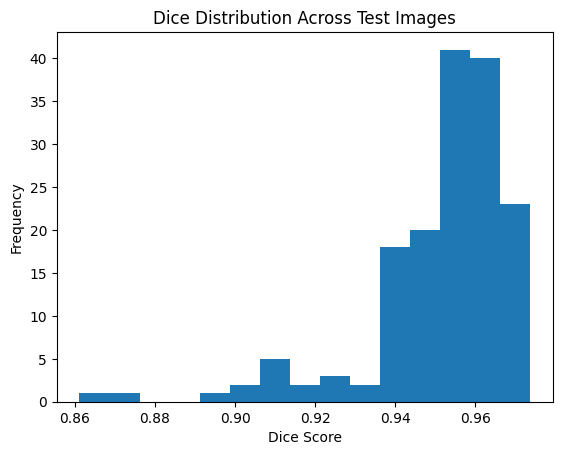

In [89]:
plt.hist(dices_np, bins=15)
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.title("Dice Distribution Across Test Images")
plt.show()

In [99]:
# t=0.95
dices = []
for name in full_predictions_test:
        prob = torch.sigmoid(full_predictions_test[name])
        pred = (prob > 0.95).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = dice_score(pred, gt)
        dices.append(d.item())

print(sum(dices)/len(dices))

0.899460697698893


###IoU

In [90]:
#t=0.5
ious = []
for name in full_predictions_test:
        prob = torch.sigmoid(full_predictions_test[name])
        pred = (prob > 0.5).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = iou_score(pred, gt)
        ious.append(d.item())

In [91]:
iou_np = np.array(ious)
print("Mean IoU:",iou_np.mean())
print("Std IoU:", iou_np.std())
print("Min IoU:", iou_np.min())
print("Max IoU:", iou_np.max())

Mean IoU: 0.9084123590457365
Std IoU: 0.032076002743054076
Min IoU: 0.7561239004135132
Max IoU: 0.9488393068313599


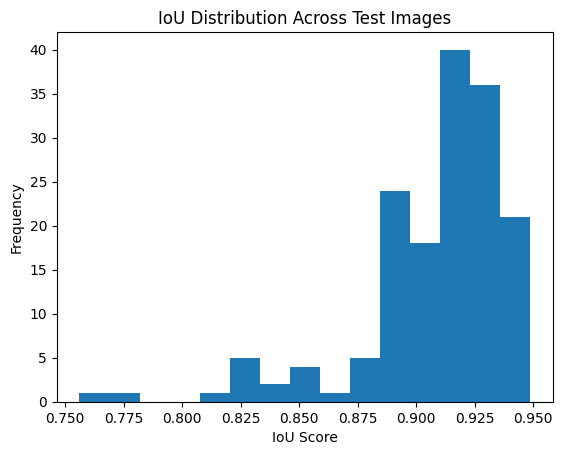

In [92]:
plt.hist(iou_np, bins=15)
plt.xlabel("IoU Score")
plt.ylabel("Frequency")
plt.title("IoU Distribution Across Test Images")
plt.show()

In [98]:
#t=0.95
ious = []
for name in full_predictions_test:
        prob = torch.sigmoid(full_predictions_test[name])
        pred = (prob > 0.95).float()
        name_gt = name.split(".")[0] + ".png"
        gt = gt_masks[name_gt].to(pred.device)

        d = iou_score(pred, gt)
        ious.append(d.item())
print(sum(ious)/len(ious))

0.8185360304214669


###Instance Level

####Metrics

In [95]:
#0.5 threshold
instance_ae = []
for name in full_predictions_test:
        pred_fg = (torch.sigmoid(full_predictions_test[name]) > 0.5).squeeze(0).cpu().numpy().astype(bool)
        pred_fg2 = binary_opening(pred_fg, disk(1))
        pred_st = connected_components_instances_from_binary(pred_fg2, min_size=100, connectivity=1)
        n_pred = instance_stats(pred_st)["num_instances"]

        name_gt = name.split(".")[0] + ".png"
        gt_rgb = io.imread(os.path.join(TEST_MASK_DIR, name_gt))
        gt_fg = rgb_white_to_binary(gt_rgb, white_thresh=200)
        gt_st = connected_components_instances_from_binary(gt_fg, min_size=100, connectivity=1)
        n_gt = instance_stats(gt_st)["num_instances"]
        instance_ae.append(abs(n_pred - n_gt))

print("Mean MAE of object number per Slide Across Test (t=0.5): ", sum(instance_ae)/len(instance_ae))

Mean MAE of object number per Slide Across Test (t=0.5):  23.57861635220126


In [94]:
#0.95 threshold
instance_ae = []
for name in full_predictions_test:
        pred_fg = (torch.sigmoid(full_predictions_test[name]) > 0.95).squeeze(0).cpu().numpy().astype(bool)
        pred_fg2 = binary_opening(pred_fg, disk(1))
        pred_st = connected_components_instances_from_binary(pred_fg2, min_size=100, connectivity=1)
        n_pred = instance_stats(pred_st)["num_instances"]

        name_gt = name.split(".")[0] + ".png"
        gt_rgb = io.imread(os.path.join(TEST_MASK_DIR, name_gt))
        gt_fg = rgb_white_to_binary(gt_rgb, white_thresh=200)
        gt_st = connected_components_instances_from_binary(gt_fg, min_size=100, connectivity=1)
        n_gt = instance_stats(gt_st)["num_instances"]
        instance_ae.append(abs(n_pred - n_gt))

print("Mean MAE of object number per Slide Across Test (t=0.95): ", sum(instance_ae)/len(instance_ae))

Mean MAE Across Test:  6.584905660377358


In [96]:
f1_out = eval_f1_iou_dataset(full_predictions_test, gt_masks, thr_mask=0.5, iou_thr=0.5, score_thr=0.0)
print(f1_out)

{'precision': 0.717169318451589, 'recall': 0.4404900816802479, 'f1': 0.5457666933027948, 'tp': 6040, 'fp': 2382, 'fn': 7672, 'iou_thr': 0.5, 'thr_mask': 0.5, 'score_thr': 0.0}


In [97]:
f1_out = eval_f1_iou_dataset(full_predictions_test, gt_masks, thr_mask=0.95, iou_thr=0.5, score_thr=0.0)
print(f1_out)

{'precision': 0.8170509205506039, 'recall': 0.7184947491248017, 'f1': 0.7646100111434437, 'tp': 9852, 'fp': 2206, 'fn': 3860, 'iou_thr': 0.5, 'thr_mask': 0.95, 'score_thr': 0.0}


In [101]:
map_out = eval_map_bbox(full_predictions_test, gt_masks, thr=0.5)
print(map_out)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


{'map': tensor(0.3491), 'map_50': tensor(0.4212), 'map_75': tensor(0.3763), 'map_small': tensor(0.), 'map_medium': tensor(0.4578), 'map_large': tensor(0.3861), 'mar_1': tensor(0.0111), 'mar_10': tensor(0.1046), 'mar_100': tensor(0.3800), 'mar_small': tensor(0.), 'mar_medium': tensor(0.4942), 'mar_large': tensor(0.4160), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


In [102]:
map_out = eval_map_bbox(full_predictions_test, gt_masks, thr=0.95)
print(map_out)

{'map': tensor(0.4722), 'map_50': tensor(0.6972), 'map_75': tensor(0.5655), 'map_small': tensor(0.), 'map_medium': tensor(0.5156), 'map_large': tensor(0.5613), 'mar_1': tensor(0.0100), 'mar_10': tensor(0.0960), 'mar_100': tensor(0.5052), 'mar_small': tensor(0.), 'mar_medium': tensor(0.5785), 'mar_large': tensor(0.5885), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


####Visualization

In [103]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_boxes(ax, boxes, color="lime", lw=1.5, label=None, alpha=1.0):
    if boxes is None:
        return
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.detach().cpu().numpy()
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, edgecolor=color, linewidth=lw, alpha=alpha))
    if label is not None:
        ax.text(0.01, 0.99, label, transform=ax.transAxes,
                va="top", ha="left", color=color,
                bbox=dict(facecolor="black", alpha=0.3, pad=2), fontsize=10)

@torch.no_grad()
def visualize_instance_failure(
    name, full_predictions, gt_masks,
    thr_mask=0.6,
    score_thr=0.0,
    figsize=(14, 9)
):

    # get probability + binarized prediction
    prob = torch.sigmoid(full_predictions[name]).detach().cpu().squeeze().numpy()
    pred_bin = (prob > thr_mask).astype(np.uint8)

    # get GT binary
    gt_key = name.split(".")[0] + ".png"
    gt = gt_masks[gt_key].detach().cpu().squeeze().numpy()
    gt_bin = (gt > 0.5).astype(np.uint8)

    # instance labeling
    gt_props, gt_lab = mask_to_instances(gt_bin)
    pr_props, pr_lab = mask_to_instances(pred_bin)

    gt_boxes, _ = props_to_boxes_scores(gt_props, prob_map=None)
    pr_boxes, pr_scores = props_to_boxes_scores(pr_props, prob_map=prob)

    # optional score filtering
    keep = pr_scores >= score_thr
    pr_boxes = pr_boxes[keep]
    pr_scores = pr_scores[keep]

    n_gt = int(gt_boxes.shape[0])
    n_pr = int(pr_boxes.shape[0])

    # plot
    fig, axs = plt.subplots(2, 3, figsize=figsize)

    axs[0, 0].imshow(prob)
    axs[0, 0].set_title("Pred prob (sigmoid)")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(pred_bin, cmap="gray")
    axs[0, 1].set_title(f"Pred bin (thr={thr_mask})")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(pr_lab, cmap="nipy_spectral")
    axs[0, 2].set_title(f"Pred instances (CC)  n={n_pr}")
    axs[0, 2].axis("off")

    axs[1, 0].imshow(gt_bin, cmap="gray")
    axs[1, 0].set_title("GT bin")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(gt_lab, cmap="nipy_spectral")
    axs[1, 1].set_title(f"GT instances  n={n_gt}")
    axs[1, 1].axis("off")

    # overlay GT and pred boxes on prob (or on GT)
    axs[1, 2].imshow(prob)
    draw_boxes(axs[1, 2], gt_boxes, color="yellow", lw=1.2, label=f"GT boxes: {n_gt}", alpha=0.9)
    draw_boxes(axs[1, 2], pr_boxes, color="lime", lw=1.2, label=f"Pred boxes: {n_pr}", alpha=0.9)
    axs[1, 2].set_title("Overlay on prob: GT(yellow) vs Pred(lime)")
    axs[1, 2].axis("off")

    fig.suptitle(f"{name} | thr_mask={thr_mask} score_thr={score_thr}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "gt_key": gt_key,
        "n_gt": n_gt,
        "n_pred": n_pr,
        "gt_boxes": gt_boxes,
        "pred_boxes": pr_boxes,
        "pred_scores": pr_scores,
    }

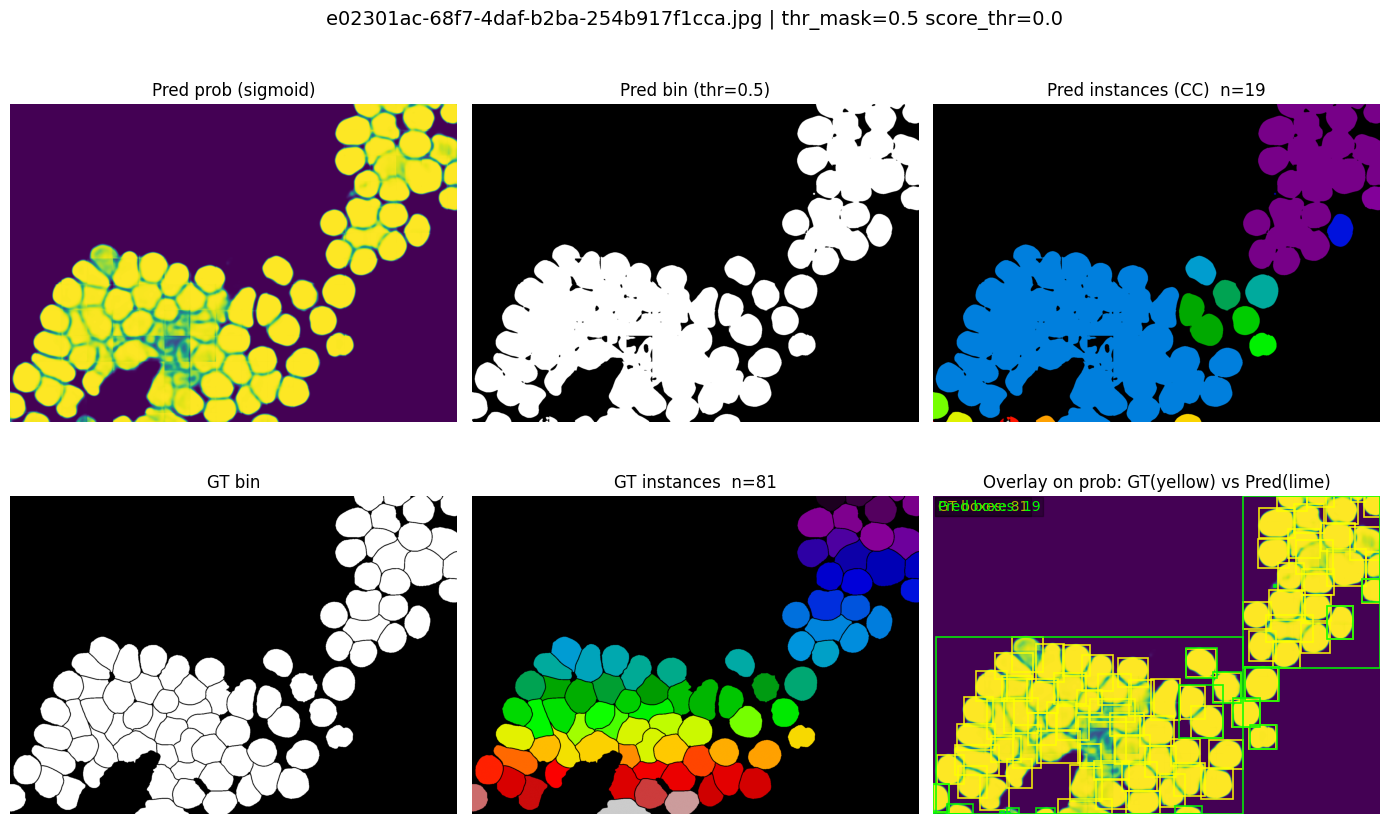

In [105]:
test_image = list(full_predictions_test.keys())[0]
out = visualize_instance_failure(test_image, full_predictions_test, gt_masks, thr_mask=0.5)

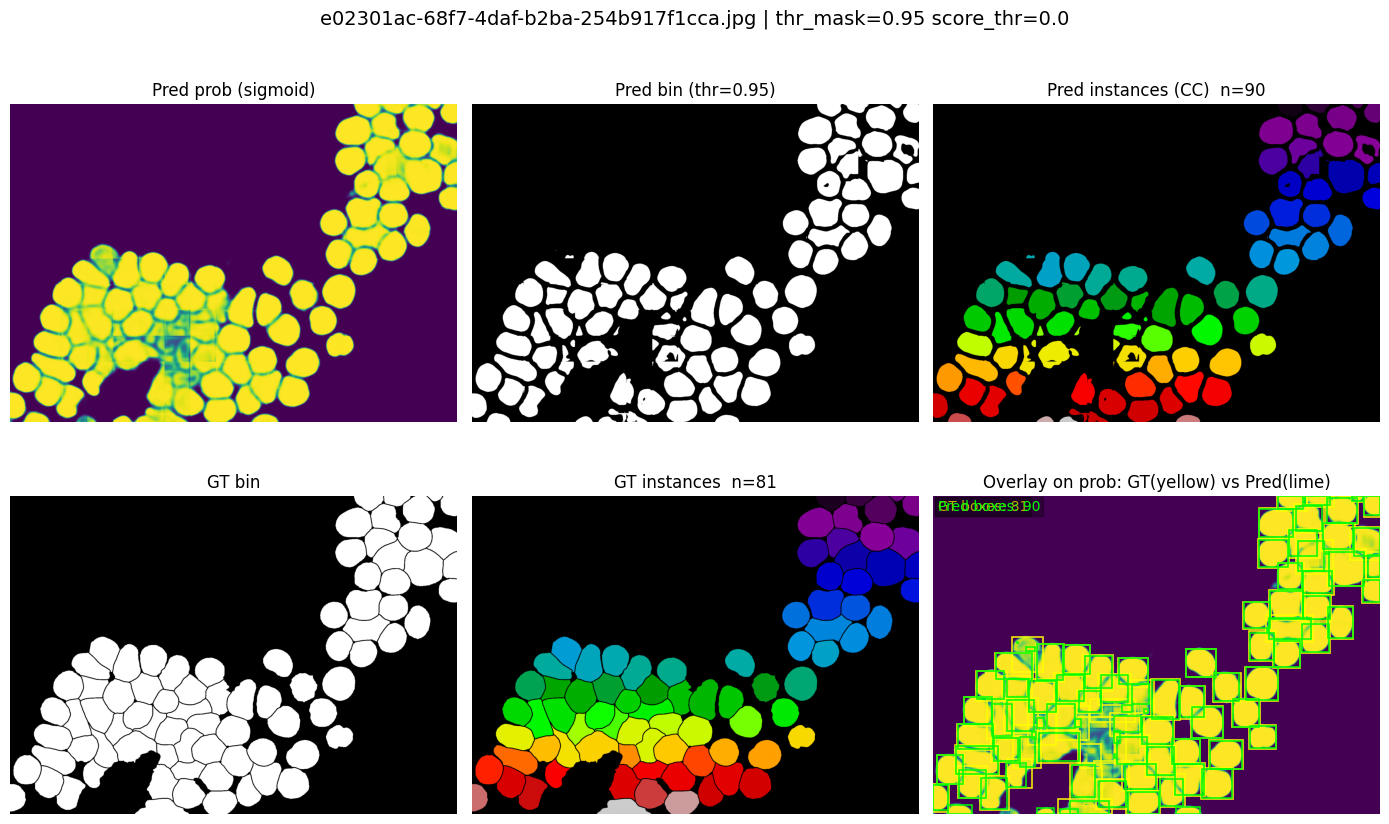

In [106]:
test_image_high = list(full_predictions_test.keys())[0]
out = visualize_instance_failure(test_image, full_predictions_test, gt_masks, thr_mask=0.95)

In [112]:
@torch.no_grad()
def find_worst_dice(full_predictions, gt_masks, thr_mask=0.6):
    dice_list = []
    for name in full_predictions:
        prob = torch.sigmoid(full_predictions[name]).detach().cpu().squeeze().numpy()
        pred_bin = (prob > thr_mask).astype(np.uint8)

        gt = gt_masks[name.split(".")[0] + ".png"].detach().cpu().squeeze().numpy()
        gt_bin = (gt > 0.5).astype(np.uint8)

        d = dice_score(pred_bin, gt_bin)
        dice_list.append((d, name))

    dice_list.sort(key=lambda x: x[0])
    return dice_list[0], dice_list  # (worst case), (all)

@torch.no_grad()
def plot_worst_case_dice(full_predictions, gt_masks, thr_mask=0.6, figsize=(14, 8)):
    (worst_d, worst_name), dice_list = find_worst_dice(full_predictions, gt_masks, thr_mask=thr_mask)

    prob = torch.sigmoid(full_predictions[worst_name]).detach().cpu().squeeze().numpy()
    pred_bin = (prob > thr_mask).astype(np.uint8)

    gt = gt_masks[worst_name.split(".")[0] + ".png"].detach().cpu().squeeze().numpy()
    gt_bin = (gt > 0.5).astype(np.uint8)

    fig, axs = plt.subplots(2, 2, figsize=figsize)

    img_path = os.path.join(TEST_IMG_DIR, worst_name)  #might be .jpg
    orig_img = np.array(Image.open(img_path).convert("RGB"))

    axs[0, 0].imshow(orig_img)
    axs[0, 0].set_title("Original image")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(pred_bin, cmap="gray")
    axs[0, 1].set_title(f"Pred bin (thr={thr_mask})")
    axs[0, 1].axis("off")

    axs[1, 0].imshow(gt_bin, cmap="gray")
    axs[1, 0].set_title("GT bin")
    axs[1, 0].axis("off")

    # overlay: red = FN, green = FP, yellow = TP pixels
    overlay = np.zeros((*gt_bin.shape, 3), dtype=np.float32)
    gt_bool = gt_bin.astype(bool)
    pr_bool = pred_bin.astype(bool)

    tp = gt_bool & pr_bool
    fn = gt_bool & (~pr_bool)
    fp = (~gt_bool) & pr_bool

    overlay[tp] = [1, 1, 0]   # yellow
    overlay[fn] = [1, 0, 0]   # red
    overlay[fp] = [0, 1, 0]   # green

    axs[1, 1].imshow(overlay)
    axs[1, 1].set_title("Overlay: TP(yellow) FN(red) FP(green)")
    axs[1, 1].axis("off")

    fig.suptitle(f"Worst Dice: {worst_d:.4f} | {worst_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

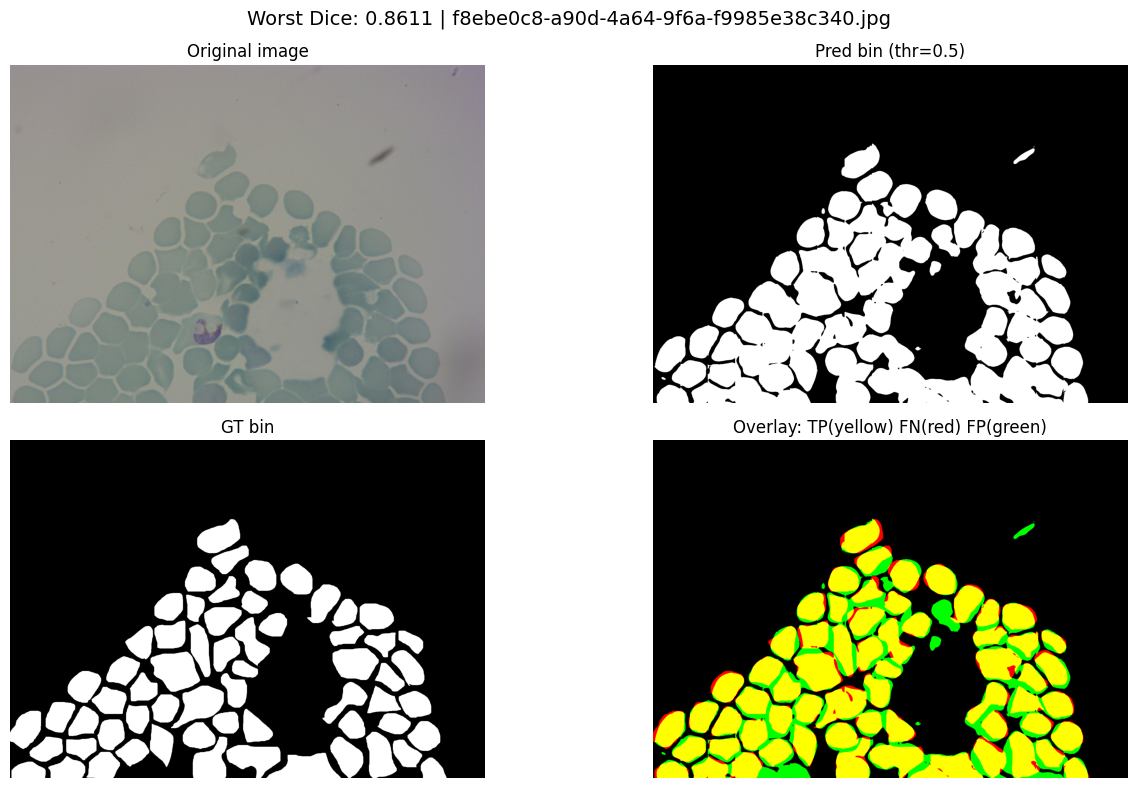

In [113]:
out = plot_worst_case_dice(full_predictions_test, gt_masks, thr_mask=0.5)

#End

UNI

In [ ]:
from huggingface_hub import login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!pip -q install -U timm

In [ ]:
import timm, torch

from transformers import AutoImageProcessor, AutoModel
print("timm:", timm.__version__)

timm: 1.0.24


In [ ]:
encoder = timm.create_model(
    "hf-hub:MahmoodLab/UNI",
    pretrained=True,
    num_classes=0,
    init_values=1e-5,       #  ls1/ls2.gamma keys
    dynamic_img_size=True,
)
encoder.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inpl